# Anime Recommendation

## Background

In this project, we want to build a better anime recommendation system based only on user viewing history. We will use user-based collaborative filtering to do the task.

In user-based collaborative filtering:
- users are deemed similar if they like similar items
- we first discover which users are similar
- then recommend items that other similar users like

For example
* Sunny likes paintings by Monet, Picasso and Dali.
* Ted likes paintings by Monet and Picasso.

Sunny and Ted are similar because they like some of the same artists. Sunny likes Dali but Ted has never seen a Dali painting.
So let's recommend Dali to Ted.

Another example:
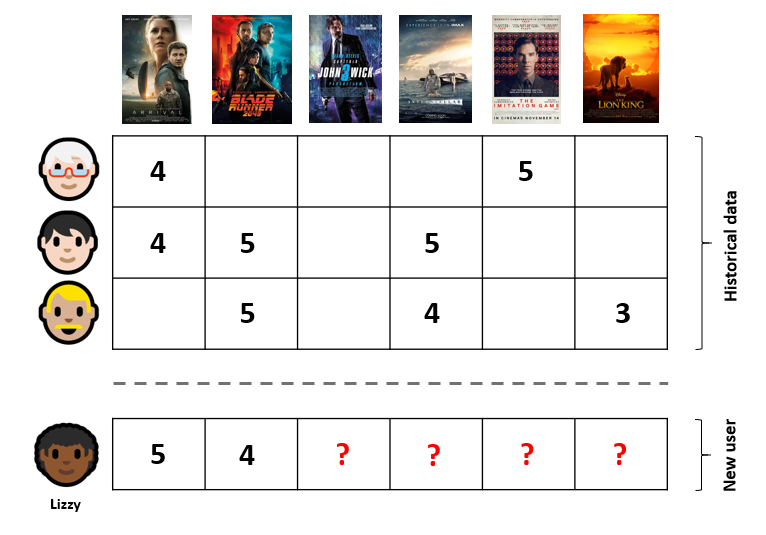

In this task, we use [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) to solve the problem.
$$
    \cos (\mathit{\Theta }) = \frac{\mathbf{A} \cdot \mathbf{B}}{\left \| \mathbf{A} \right \| \left \| \mathbf{B} \right \|}
$$


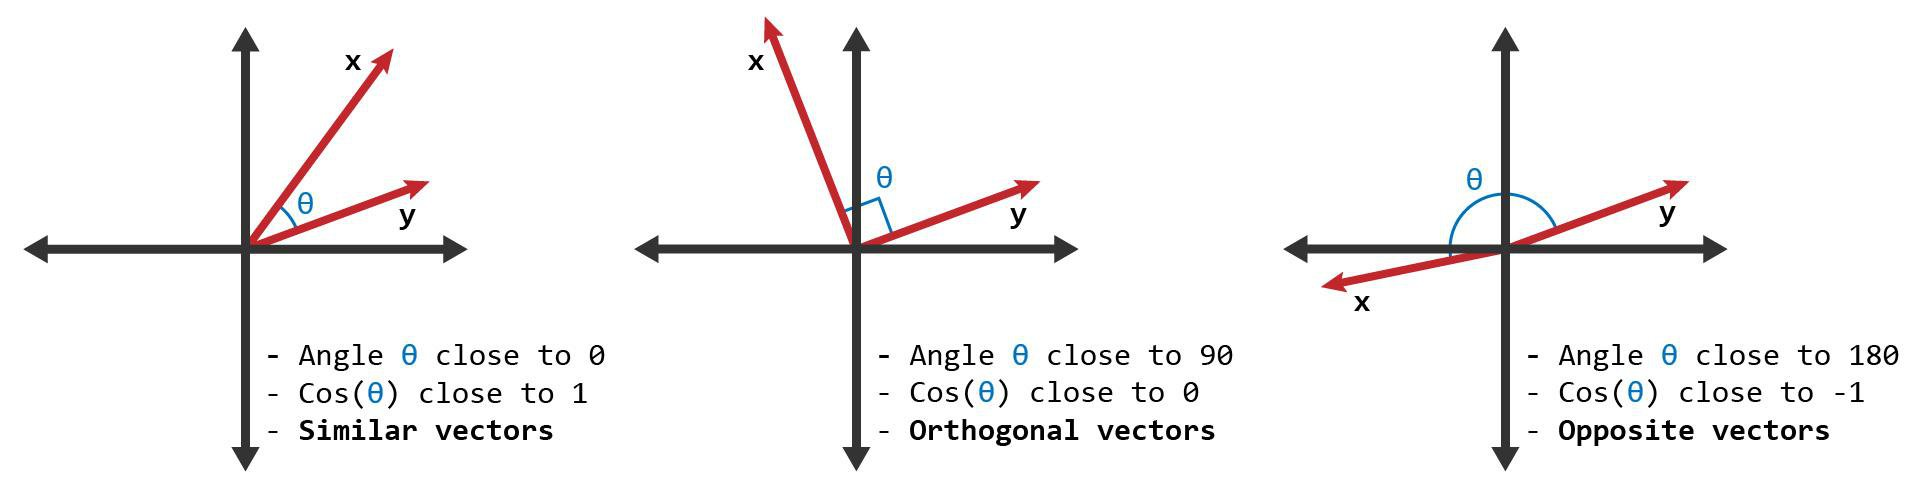

## Prepare and Explore the Data

For this experiment, we will use [this](https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database?resource=download&select=anime.csv) data from Kaggle platform.

In [2]:
# Package imports
from zipfile import ZipFile

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statistics

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Load anime.csv
animes = pd.read_csv('anime.csv')

animes.head()

anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
3                                   Sci-Fi, Thriller     TV       24    9.17   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.16   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266

* members = banyaknya user yang rating anime tersebut

In [4]:
animes.anime_id.nunique()

12294

Some simple descriptive statistic.

In [5]:
# Descriptive statistic
animes[["rating", "members"]].describe()

rating       members
count  12064.000000  1.229400e+04
mean       6.473902  1.807134e+04
std        1.026746  5.482068e+04
min        1.670000  5.000000e+00
25%        5.880000  2.250000e+02
50%        6.570000  1.550000e+03
75%        7.180000  9.437000e+03
max       10.000000  1.013917e+06

In [6]:
# Grouped descriptive statistics
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
animes \
    .groupby('type')["rating"] \
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max']) \
    .transpose()

type        Movie     Music       ONA       OVA   Special        TV
mean     6.318058  5.588996  5.643298  6.375221  6.523501  6.902299
std      1.211988  0.958440  1.127091  0.858358  0.887762  0.863526
min      1.920000  3.280000  2.580000  2.000000  1.670000  2.670000
q25      5.420000  5.010000  4.870000  5.850000  6.085000  6.440000
median   6.470000  5.625000  5.755000  6.380000  6.630000  6.940000
q75      7.250000  6.152500  6.412500  6.920000  7.110000  7.460000
max     10.000000  8.380000  8.260000  9.250000  8.660000  9.600000

Information about dataset from the docs.

* `anime_id` - myanimelist.net's unique id identifying an anime.
* `name` - full name of anime.
* `genre` - comma separated list of genres for this anime.
* `type` - movie, TV, OVA, etc.
* `episodes` - how many episodes in this show. (1 if movie).
* `rating` - average rating out of 10 for this anime.
* `members` - number of community members that are in this anime's "group".

In [7]:
# Load rating.csv
ratings = pd.read_csv('rating.csv')

ratings.head()

user_id  anime_id  rating
0        1        20      -1
1        1        24      -1
2        1        79      -1
3        1       226      -1
4        1       241      -1

Information about dataset from the docs.

* `user_id` - non identifiable randomly generated user id.
* `anime_id` - the anime that this user has rated.
* `rating` - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

From the documentation above, we knew that rating = -1 means that the user watched the anime but didn't assign a rating. We could remove those data since it doesn't added any additional information.

In [8]:
# remove rating -1
ratings = ratings[ratings["rating"] != -1]

ratings.groupby(["rating"])["rating"].count()

rating
1       16649
2       23150
3       41453
4      104291
5      282806
6      637775
7     1375287
8     1646019
9     1254096
10     955715
Name: rating, dtype: int64

In [9]:
ratings['user_id'].nunique()

69600

In [10]:
animes.anime_id.nunique()

12294

There are 6337241 rating posted
There are 69600 people rated
There are 12294 unique anime


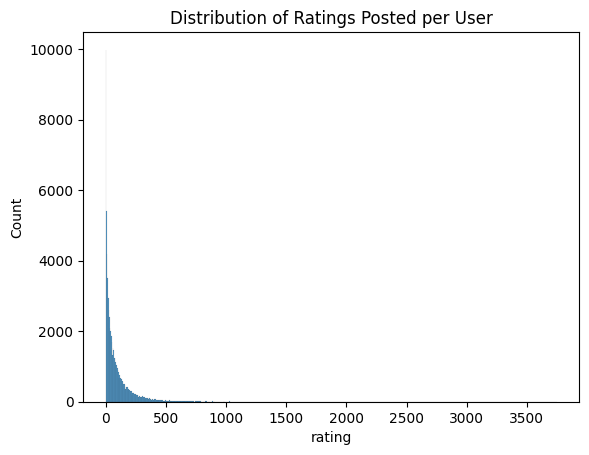

In [11]:
# number of ratings
print('There are', str(len(ratings)), 'rating posted')
# number of users
print('There are', str(ratings['user_id'].nunique()),'people rated')
# number of unique animes (in anime list, not ratings)
print('There are', str(animes['anime_id'].nunique()), 'unique anime')
# avg number of anime rated per user
ratings_per_user = ratings.groupby('user_id')['rating'].count()
statistics.mean(ratings_per_user.to_list())
# distribution of ratings posted per user
_ = plt.title('Distribution of Ratings Posted per User')
_ = sns.histplot(ratings_per_user)
plt.show()
# jika pakai unique -> pakai len
# jika pakai nunique -> tidak perlu pakai len

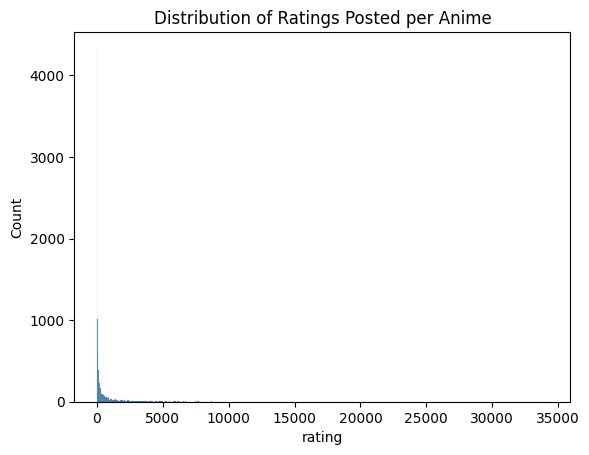

In [12]:
# avg number rating given per anime
ratings_per_anime = ratings.groupby('anime_id')['rating'].count()
statistics.mean(ratings_per_anime.to_list())

# distribution of ratings per anime
_ = plt.title('Distribution of Ratings Posted per Anime')
_ = sns.histplot(ratings_per_anime)
plt.show()

## Build Recommender

In user-based collaborative filtering, vectors representing users are essentially lists of the ratings they’ve given. So the more anime in our universe, the more dimensionality per user.

Let's reduce the amount of data to crunch by removing anime that hasn’t been rated by many users. Make a list of anime to keep based on id.

In [13]:
# counts of ratings per anime as a df
ratings_per_anime_df = pd.DataFrame(ratings_per_anime)

# remove if < 1000 ratings
filtered_ratings_per_anime_df = ratings_per_anime_df[ratings_per_anime_df['rating'] >= 1000]

# build a list of anime_ids to keep -> using .index .tolist
popular_anime = filtered_ratings_per_anime_df.index.tolist()

In [14]:
len(popular_anime)

1462

* Dimension of anime reduce from 12000-ish to 1462

And users who haven’t rated many anime.

In [15]:
# counts ratings per user as a df
ratings_per_user_df = pd.DataFrame(ratings_per_user)
# remove if < 500
filtered_ratings_per_user_df = ratings_per_user_df[ratings_per_user_df['rating'] >= 500]
# build a list of user_ids to keep
popular_user = filtered_ratings_per_user_df.index.tolist()
len(popular_user)

1365

In [16]:
print(ratings['anime_id'].shape)
print(ratings['user_id'].shape)

(6337241,)
(6337241,)


* Dimension of user reduce from 69600 to 1365

Now filter out anime and users not in those lists.

In [17]:
filter_ratings = ratings[ratings['anime_id'].isin(popular_anime)]
filter_ratings = ratings[ratings['user_id'].isin(popular_user)]
len(filter_ratings)

# isin -> ada didalam (bentuknya list)
# kolom anime_id & user_id pada dataset ratings akan difilter berdasarkan list pada popular_anime & popular_user

1005314

In [18]:
filter_ratings.head()

user_id  anime_id  rating
17304      226         1       8
17305      226         6       8
17306      226        20       7
17307      226        25       6
17308      226        27       7

We’re down from 6M to 1M rating data points. Nice.

Let's build a rating matrix between users and animes.

In [19]:
rating_matrix = filter_ratings.pivot_table(index='user_id',columns='anime_id', values = 'rating')

In [20]:
# replace NaN values with 0
rating_matrix = rating_matrix.fillna(0)

# display the top few rows
rating_matrix.head(15)

anime_id  1      5      6      7      8      15     16     17     18     \
user_id                                                                   
226         8.0    0.0    8.0    0.0    0.0    0.0    0.0    0.0    0.0   
271         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
294         7.0    7.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
392         7.0    0.0    7.0    0.0    0.0    0.0    0.0    0.0    7.0   
446         9.0    8.0    9.0    0.0    0.0    0.0    0.0    0.0    0.0   
478         0.0    0.0    0.0    0.0    0.0    0.0    8.0    0.0    0.0   
661         0.0    0.0    0.0    0.0    0.0    8.0    0.0    0.0    0.0   
741        10.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
771         8.0    7.0    8.0    0.0    0.0    0.0    7.0    0.0    0.0   
786         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
958        10.0   10.0    0.0    0.0    0.0    0.0    0.0    0.0    9.0   
1019        0.0    0.0    0.0    0.0    0.0    7.0    0.0    0.0    0.0   
1103        9.0    0.0    0.0    0.0    0.0    0.0    8.0    0.0    0.0   
1145        0.0    0.0    8.0    0.0    0.0    0.0    8.0    0.0    0.0   
1176        9.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

anime_id  19     20     22     23     24     25     26     27     28     \
user_id                                                                   
226         0.0    7.0    0.0    0.0    0.0    6.0    0.0    7.0    0.0   
271         0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
294         0.0   10.0    0.0    0.0    8.0    0.0    0.0    0.0    0.0   
392         0.0    7.0    0.0    0.0    0.0    0.0    0.0    0.0    7.0   
446        10.0    0.0    0.0    0.0    0.0    0.0    9.0    8.0    0.0   
478         0.0    9.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
661         9.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
741         0.0    7.0    0.0    0.0    8.0    0.0    0.0    0.0    0.0   
771         8.0    0.0    0.0    0.0    7.0    5.0    0.0    0.0    0.0   
786         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
958        10.0    9.0    0.0    0.0    9.0    0.0    0.0    0.0    0.0   
1019        0.0    0.0    0.0    0.0    9.0    0.0    0.0    0.0    7.0   
1103        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1145        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1176        8.0    7.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

anime_id  29     30     31     32     33     43     44     45     46     \
user_id                                                                   
226         0.0    0.0    0.0    0.0    0.0    0.0    0.0    8.0    0.0   
271         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
294         0.0    7.0    7.0    8.0    0.0    0.0    9.0    7.0    7.0   
392         0.0    0.0    0.0    0.0    7.0    0.0   10.0    7.0    8.0   
446         0.0    0.0    0.0    0.0    9.0    9.0    0.0    0.0    0.0   
478         0.0    9.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
661         0.0   10.0    8.0    9.0    0.0   10.0    0.0    0.0    0.0   
741         0.0    7.0    7.0    9.0    0.0   10.0    0.0    8.0    0.0   
771         0.0    7.0    0.0    7.0    0.0    0.0    0.0    0.0    0.0   
786         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
958         0.0    8.0    8.0    8.0    0.0    0.0    0.0    0.0    0.0   
1019        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1103        0.0    0.0    0.0    0.0    5.0    0.0    0.0    0.0    0.0   
1145        0.0    9.0    0.0   10.0    7.0    0.0    0.0    0.0    0.0   
1176        0.0    8.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

anime_id  47     48     49     50     51     52     53     54     55     \
user_id                                                                   
226         0.0    7.0

Write a function to find the most similar users to the current_user using cosine similarity. We’ve arbitrarily decided to find the 3 most similar users.

And picked “226” as our current user, but we could have picked anyone.

In [34]:
from sklearn.metrics.pairwise import cosine_similarity
import operator

def similar_users(user_id, matrix, k=3):
    # create a df of just the current user
    user = matrix[matrix.index == user_id] # catch the 226 user_id

    # and a df of all other users
    other_user = matrix[matrix.index != user_id] # user_id exclide 226
    
    # calc cosine similarity between user and each other user
    similarities = cosine_similarity(user,other_user)[0].tolist() # starting cosine similarity
    
    # create list of indices of these users
    indicies = other_user.index.tolist() # 
    
    # create key/values pairs of user index and their similarity
    index_similarity = dict(zip(indicies,similarities))
    
    # sort by similarity
    index_similarity_sorted = sorted(index_similarity.items(),key = operator.itemgetter(1))
    index_similarity_sorted.reverse()
    
    # grab k users off the top
    top_users_simimilarities = index_similarity_sorted[:k]
    users = [u[0] for u in top_users_simimilarities]
    return users

current_user = 226

# try it out
similar_user_indices = similar_users(current_user, rating_matrix)
print(similar_user_indices)

[30773, 39021, 45603]


Now write a function to make the recommendation. We’ve set the function to return the 5 top recommended anime.

In [33]:
def recommend_item(user_index, similar_user_indices, matrix, items=5):

    # load vectors for similar users
    similar_users = matrix[matrix.index.isin(similar_user_indices)] # compare current user with similar user
    
    # calc avg ratings across the 3 similar users
    similar_users = similar_users.mean(axis = 0)
    
    # convert to dataframe so its easy to sort and filter
    similar_users_df = pd.DataFrame(similar_users, columns=['mean'])

    # load vector for the current user
    user_df = matrix[matrix.index == user_index]
    
    # transpose it so its easier to filter
    user_df_transposed = user_df.transpose()
    
    # rename the column as 'rating'
    user_df_transposed.columns = ['rating']
    
    # remove any rows with a 0 value. Anime not watched yet
    user_df_transposed = user_df_transposed[user_df_transposed['rating'] == 0]
    
    # generate a list of animes the user has not seen
    animes_unseen = user_df_transposed.index.tolist()
    
    # filter avg ratings of similar users for only anime the current user has not seen
    similar_users_df_filtered = similar_users_df[similar_users_df.index.isin(animes_unseen)]
    # order the dataframe
    similar_users_ordered = similar_users_df_filtered.sort_values(by=['mean'], ascending=False)
    
    # grab the top n anime
    top_n_anime = similar_users_ordered.head(items)
    top_n_anime_indicies = top_n_anime.index.tolist()
    
    # lookup these anime in the other dataframe to find names
    anime_information = animes[animes['anime_id'].isin(top_n_anime_indicies)]

    return anime_information #items

# try it out
recommend_item(226, similar_user_indices, rating_matrix)

anime_id                                               name  \
56       5300                            Zoku Natsume Yuujinchou   
57       9989  Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...   
83        877                                               Nana   
91      13125                                     Shinsekai yori   
270     30015                                             ReLIFE   

                                                 genre type episodes  rating  \
56   Drama, Fantasy, Shoujo, Slice of Life, Superna...   TV       13    8.64   
57                  Drama, Slice of Life, Supernatural   TV       11    8.62   
83   Comedy, Drama, Music, Romance, Shoujo, Slice o...   TV       47    8.55   
91        Drama, Horror, Mystery, Sci-Fi, Supernatural   TV       25    8.53   
270                     Romance, School, Slice of Life   TV       13    8.24   

     members  
56    114173  
57    463835  
83    197256  
91    288376  
270   202249

There we have it! The 5 highest-rated anime from the most similar users that our current user has not yet watched.

# Question

1. Bagaimana jika recommendation system hanya dikhusukan untuk rekomendasi film (type='Movie')? Buat rekomendasi 5 film rekomendasi untuk user_id 226 berdasarkan 5 user paling mirip dengan user_id 226.

* 5 user paling mirip dengan user_id 226

In [42]:
from sklearn.metrics.pairwise import cosine_similarity
import operator

def similar_users(user_id, matrix, k=5):
    # create a df of just the current user
    user = matrix[matrix.index == user_id] # catch the 226 user_id

    # and a df of all other users
    other_user = matrix[matrix.index != user_id] # user_id exclude 226
    
    # calc cosine similarity between user and each other user
    similarities = cosine_similarity(user,other_user)[0].tolist() # starting cosine similarity
    
    # create list of indices of these users
    indicies = other_user.index.tolist() # 
    
    # create key/values pairs of user index and their similarity
    index_similarity = dict(zip(indicies,similarities))
    
    # sort by similarity
    index_similarity_sorted = sorted(index_similarity.items(),key = operator.itemgetter(1))
    index_similarity_sorted.reverse()
    
    # grab k users off the top
    top_users_simimilarities = index_similarity_sorted[:k]
    users = [u[0] for u in top_users_simimilarities]
    return users

current_user = 226

# try it out
similar_user_indices = similar_users(current_user, rating_matrix)
print(similar_user_indices)

[30773, 39021, 45603, 24130, 17479]


Recomend Item

In [43]:
def recommend_item(user_index, similar_user_indices, matrix, types, items=5):

    # load vectors for similar users
    similar_users = matrix[matrix.index.isin(similar_user_indices)] # compare current user with similar user
    
    # calc avg ratings across the 5 similar users
    similar_users = similar_users.mean(axis = 0)
    
    # convert to dataframe so its easy to sort and filter
    similar_users_df = pd.DataFrame(similar_users, columns=['mean'])

    # load vector for the current user
    user_df = matrix[matrix.index == user_index]
    
    # transpose it so its easier to filter
    user_df_transposed = user_df.transpose()
    
    # rename the column as 'rating'
    user_df_transposed.columns = ['rating']
    
    # remove any rows with a 0 value. Anime not watched yet
    user_df_transposed = user_df_transposed[user_df_transposed['rating'] == 0]
    
    # generate a list of animes the user has not seen
    animes_unseen = user_df_transposed.index.tolist()
    
    # filter avg ratings of similar users for only anime the current user has not seen
    similar_users_df_filtered = similar_users_df[similar_users_df.index.isin(animes_unseen)]
    
    # order the dataframe
    similar_users_ordered = similar_users_df_filtered.sort_values(by=['mean'], ascending=False)
    
    similar_users_df_indices = similar_users_ordered.index.tolist()
    
    # lookup these anime in the other dataframe to find names
    anime_information = animes[(animes['anime_id'].isin(similar_users_df_indices)) & (animes['type'] == types)].head(items)
    
    return anime_information #items

# try it out
recommend_item(226, similar_user_indices, rating_matrix, types='Movie')

anime_id                                               name  \
0      32281                                     Kimi no Na wa.   
8      15335  Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...   
11     28851                                     Koe no Katachi   
15       199                      Sen to Chihiro no Kamikakushi   
18     12355                       Ookami Kodomo no Ame to Yuki   

                                                genre   type episodes  rating  \
0                Drama, Romance, School, Supernatural  Movie        1    9.37   
8   Action, Comedy, Historical, Parody, Samurai, S...  Movie        1    9.10   
11                             Drama, School, Shounen  Movie        1    9.05   
15                     Adventure, Drama, Supernatural  Movie        1    8.93   
18                             Fantasy, Slice of Life  Movie        1    8.84   

    members  
0    200630  
8     72534  
11   102733  
15   466254  
18   226193

# Kesimpulan

* user yang memiliki prefrensi yang sama dengan user 226 adalah user : 30773, 39021, 45603, 24130, 17479
* user 226 memiliki refrensi genre Movie yaitu : Drama, School, dan Shounen